In [2]:
import pandas as pd
InstagramDF=pd.read_csv('InstagramDatasetRegression.csv', encoding='utf-8-sig')

In [6]:
import numpy as np
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb

In [7]:
X = InstagramDF
Y = X['number_of_likes/mean'].values
X = X.drop('number_of_likes/mean', axis = 1).values

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

In [23]:
import warnings
warnings.filterwarnings('ignore')
all_regressors = []
all_regressors.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
all_regressors.append(('LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
all_regressors.append(('EN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
all_regressors.append(('Ridge', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
all_regressors.append(('BYR', Pipeline([('Scaler', StandardScaler()),('BYR', BayesianRidge())])))
all_regressors.append(('KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
all_regressors.append(('CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
all_regressors.append(('SVM', Pipeline([('Scaler', StandardScaler()),('SVM', svm.SVR())])))
all_regressors.append(('XGB', Pipeline([('Scaler', StandardScaler()),('XGB', xgb.XGBRegressor())])))

train_error = []
test_error = []
train_error2 = []
test_error2 = []
for name, model in all_regressors:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results_train = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='mean_squared_error')
    cv_results_test = cross_val_score(model, X_test, Y_test, cv=kfold, scoring='mean_squared_error')
    cv_results_train2 = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
    cv_results_test2 = cross_val_score(model, X_test, Y_test, cv=kfold, scoring='r2')
    train_error.append(cv_results_train.mean())
    test_error.append(cv_results_test.mean())
    train_error2.append(cv_results_train2.mean())
    test_error2.append(cv_results_test2.mean())

In [24]:
col={'Train Error MSE':train_error,'Test Error MSE':test_error, 'Train Error R^2':train_error2,'Test Error R^2':test_error2}
models=['Linear Regression', 'Lasso Regression', 'ElasticNet', 'Ridge Regression', 'Bayesian Regression','KNN','Decision Tree','SVM', 'XGBoost']
df=pd.DataFrame(data=col,index=models)
df

,Test Error MSE,Test Error R^2,Train Error MSE,Train Error R^2
Linear Regression,-0.265853,0.024824,-0.241637,0.043392
Lasso Regression,-0.273798,-0.003683,-0.252769,-0.000751
ElasticNet,-0.273798,-0.003683,-0.252769,-0.000751
Ridge Regression,-0.265810,0.024992,-0.241637,0.043390
Bayesian Regression,-0.264739,0.029213,-0.241568,0.043662
KNN,-0.308872,-0.139583,-0.285912,-0.132389
Decision Tree,-0.526820,-1.019021,-0.514697,-1.037114
SVM,-0.275927,-0.011795,-0.251827,0.003092
XGBoost,-0.267621,0.017558,-0.240816,0.046508


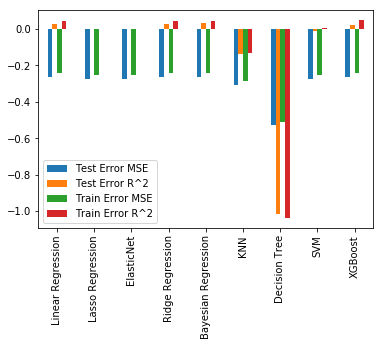

In [25]:
df.plot(kind='bar')

In [26]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [32]:
df = InstagramDF

In [33]:
df = df.rename(columns={'number_of_likes/mean': 'number_of_likes_over_mean', '(0, 4]': 'zero_to_four', '(4, 8]': 'four_to_eight', '(8, 12]': 'eight_to_twelve', '(12, 16]': 'twelve_to_sixteen', '(16, 20]': 'sixteen_to_twenty','(20, 24]': 'twenty_to_twentyfour'})

In [43]:
target = 'number_of_likes_over_mean'
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['number_of_likes_over_mean'],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Mean Squared Error : %.4g" % metrics.mean_squared_error(dtrain['number_of_likes_over_mean'].values, dtrain_predictions))
    print("R^2 Score (Train): %f" % metrics.r2_score(dtrain['number_of_likes_over_mean'], dtrain_predictions))

In [46]:
predictors = [x for x in df.columns if x not in [target]]
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, df, predictors)


Model Report
Mean Squared Error : 0.229
R^2 Score (Train): 0.108499


In [47]:
xgb1.n_estimators

37

In [48]:
param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=37, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df[predictors],df[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.24368, std: 0.00993, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.24361, std: 0.00983, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.24358, std: 0.00980, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.24416, std: 0.01019, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.24431, std: 0.01013, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.24381, std: 0.01012, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.24588, std: 0.01031, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.24617, std: 0.00975, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.24545, std: 0.01002, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.24823, std: 0.01039, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.24837, std: 0.01116, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.24825, std: 0.01008, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_chil

In [49]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate=0.1, n_estimators=37, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df[predictors],df[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.24398, std: 0.00983, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.24399, std: 0.00982, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: -0.24397, std: 0.00983, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -0.24352, std: 0.00987, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.24358, std: 0.00980, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.24347, std: 0.00990, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.24358, std: 0.00980, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.24344, std: 0.00983, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.24350, std: 0.00999, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 5},
 -0.2434378496156539)

In [50]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=37, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df[predictors],df[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.24344, std: 0.00983, params: {'gamma': 0.0},
  mean: -0.24344, std: 0.00983, params: {'gamma': 0.1},
  mean: -0.24350, std: 0.00977, params: {'gamma': 0.2},
  mean: -0.24358, std: 0.00985, params: {'gamma': 0.3},
  mean: -0.24357, std: 0.00983, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.2434378496156539)

In [51]:
xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, df, predictors)


Model Report
Mean Squared Error : 0.2346
R^2 Score (Train): 0.086925


In [52]:
xgb2.n_estimators

42

In [53]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=42, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df[predictors],df[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.24347, std: 0.01026, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.24366, std: 0.00999, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.24298, std: 0.00993, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.24349, std: 0.01027, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.24347, std: 0.01016, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.24322, std: 0.00997, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.24335, std: 0.00974, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.24335, std: 0.01012, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.24387, std: 0.00980, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.24338, std: 0.01002, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.24330, std: 0.00980, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.24346, std: 0.01030, params: {'colsample_bytree': 0.8,

In [55]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=42, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.6,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df[predictors],df[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.24349, std: 0.00984, params: {'colsample_bytree': 0.55, 'subsample': 0.75},
  mean: -0.24321, std: 0.00990, params: {'colsample_bytree': 0.55, 'subsample': 0.8},
  mean: -0.24350, std: 0.01010, params: {'colsample_bytree': 0.55, 'subsample': 0.85},
  mean: -0.24330, std: 0.01010, params: {'colsample_bytree': 0.6, 'subsample': 0.75},
  mean: -0.24298, std: 0.00993, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.24338, std: 0.01001, params: {'colsample_bytree': 0.6, 'subsample': 0.85},
  mean: -0.24339, std: 0.01021, params: {'colsample_bytree': 0.65, 'subsample': 0.75},
  mean: -0.24331, std: 0.00974, params: {'colsample_bytree': 0.65, 'subsample': 0.8},
  mean: -0.24345, std: 0.01015, params: {'colsample_bytree': 0.65, 'subsample': 0.85}],
 {'colsample_bytree': 0.6, 'subsample': 0.8},
 -0.24298064987535453)

In [59]:
param_test6 = {
    'reg_alpha':[0.5, 1, 5, 10, 50],
    'reg_lambda':[5e-4, 1e-3, 5e-3]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=42, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.6,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(df[predictors],df[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.24310, std: 0.00981, params: {'reg_alpha': 0.5, 'reg_lambda': 0.0005},
  mean: -0.24310, std: 0.00981, params: {'reg_alpha': 0.5, 'reg_lambda': 0.001},
  mean: -0.24314, std: 0.00977, params: {'reg_alpha': 0.5, 'reg_lambda': 0.005},
  mean: -0.24300, std: 0.00993, params: {'reg_alpha': 1, 'reg_lambda': 0.0005},
  mean: -0.24298, std: 0.00994, params: {'reg_alpha': 1, 'reg_lambda': 0.001},
  mean: -0.24301, std: 0.00992, params: {'reg_alpha': 1, 'reg_lambda': 0.005},
  mean: -0.24338, std: 0.00986, params: {'reg_alpha': 5, 'reg_lambda': 0.0005},
  mean: -0.24338, std: 0.00986, params: {'reg_alpha': 5, 'reg_lambda': 0.001},
  mean: -0.24338, std: 0.00986, params: {'reg_alpha': 5, 'reg_lambda': 0.005},
  mean: -0.24344, std: 0.00991, params: {'reg_alpha': 10, 'reg_lambda': 0.0005},
  mean: -0.24344, std: 0.00991, params: {'reg_alpha': 10, 'reg_lambda': 0.001},
  mean: -0.24344, std: 0.00991, params: {'reg_alpha': 10, 'reg_lambda': 0.005},
  mean: -0.24490, std: 0.01005, params:

In [62]:
xgb3 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 reg_alpha=1,
 reg_lambda=0.001,   
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, df, predictors)


Model Report
Mean Squared Error : 0.2347
R^2 Score (Train): 0.086571


In [63]:
xgb4 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 reg_alpha=1,
 reg_lambda=0.001,  
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, df, predictors)


Model Report
Mean Squared Error : 0.2353
R^2 Score (Train): 0.084220


In [68]:
print(np.sqrt(metrics.mean_squared_error(df['number_of_likes_over_mean'], xgb4.predict(df[predictors]))))

0.485043951796


In [88]:
compare = pd.DataFrame({'Prediction': xgb4.predict(df[predictors]), 'Actual' : df['number_of_likes_over_mean']})
compare.head(23)

,Actual,Prediction
0,0.697678,1.019311
1,1.132276,0.995016
2,0.641902,1.004327
3,1.072790,1.049631
4,1.059753,1.015065
5,1.177626,1.048099
6,1.101678,1.016622
7,1.154272,1.051312
8,1.012914,1.020844
9,1.057489,1.028038


In [81]:
Small_difference = abs((df["number_of_likes_over_mean"].values) - xgb4.predict(df[predictors]))  < 0.1
med_difference = abs((df["number_of_likes_over_mean"].values) - xgb4.predict(df[predictors]))  < 0.25
Big_difference = abs((df["number_of_likes_over_mean"].values) - xgb4.predict(df[predictors]))  > 0.5

In [80]:
df[Small_difference].shape[0]

4273

In [82]:
df[med_difference].shape[0]

9900

In [75]:
idx_vals = df[Small_difference].index.values
idx_big_vals = df[Big_difference].index.values
compare1 = compare.ix[idx_vals]
compare2 = compare.ix[idx_big_vals]

In [89]:
compare1.head(10)

,Prediction,Test Data
3,1.049631,1.072790
4,1.015065,1.059753
8,1.020844,1.012914
9,1.028038,1.057489
14,1.057383,1.102865
15,1.053349,1.064485
23,1.055446,1.055596
34,1.063966,1.019667
40,1.007608,0.958649
46,1.027813,0.979036


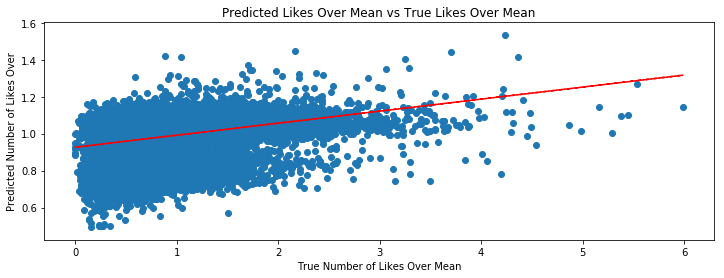

In [91]:
from  matplotlib import pyplot 
pyplot.scatter(df["number_of_likes_over_mean"].values, xgb4.predict(df[predictors]))
z = np.polyfit(df["number_of_likes_over_mean"].values, xgb4.predict(df[predictors]), 1)
p = np.poly1d(z)
pyplot.plot(df["number_of_likes_over_mean"].values,p(df["number_of_likes_over_mean"].values),"r--")
pyplot.title("Predicted Likes Over Mean vs True Likes Over Mean")
pyplot.xlabel("True Number of Likes Over Mean")
pyplot.ylabel("Predicted Number of Likes Over")
pyplot.show()